In [1]:
import yfinance as yf 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
plt.style.use('dark_background')
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

end_date = datetime.datetime.now()

# Get Data

In [2]:
start_date = '2019-01-01'
ticker_list = ['AAPL', 'AMZN','PEP', 'SONY', 'TSLA']
all_data = yf.download(ticker_list, start_date, end_date)

[*********************100%***********************]  5 of 5 completed


## Alter data to use, and split data for portfolio creation and forward testing

In [3]:
all_prices = all_data['Adj Close']
all_prices = all_prices.reset_index(inplace=False)
all_prices = all_prices.set_index('Date')
halfway = int(len(all_prices.index)/2)
# Split prices into front prices for portfolio
# and back prices for future testing
front_prices = all_prices.iloc[:halfway,:]
back_prices = all_prices.iloc[halfway:,:]

## Calculate returns and stock cov/cor matrices

In [4]:
returns = front_prices.pct_change()
cov_matrix1 = returns.cov()*252
cov_matrix1

,AAPL,AMZN,PEP,SONY,TSLA
AAPL,0.129202,0.069044,0.063511,0.070128,0.099192
AMZN,0.069044,0.079764,0.043932,0.058292,0.069864
PEP,0.063511,0.043932,0.072516,0.048127,0.044662
SONY,0.070128,0.058292,0.048127,0.100746,0.062915
TSLA,0.099192,0.069864,0.044662,0.062915,0.407010


## Expected Return

In [5]:
er = (returns.mean())
# Annualizing average daily returns
for x in range(0,4):
    er[x]=((er[x]+1)**252)-1
print(er)

AAPL    0.601432
AMZN    0.189511
PEP     0.216196
SONY    0.166919
TSLA    0.001895
dtype: float64


# Create portfolios to find EF

In [6]:
p_ret=[]
p_vol=[]
p_weights = []
num_stocks = len(ticker_list)

num_assets = len(returns.columns)
num_portfolios = int(10000 *10**(1 + (num_stocks/10)))

In [7]:
for single_portfolio in (range(num_portfolios)):
    #clear_output(wait=True)
    
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    rets = np.dot(weights, er)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix1, weights)))
    p_ret.append(rets)
    p_vol.append(volatility)
    p_weights.append(weights)
    
    #print('Current progress:', np.round(single_portfolio/num_portfolios *100, 2), '%')

## Compile portfolios into dataframe

In [8]:
data1 = {'Returns': p_ret, 'Volatility': p_vol}
for counter, symbol in enumerate(returns.columns.tolist()):
    data1[symbol+ ' Weight'] = [w[counter] for w in p_weights]
portfolios = pd.DataFrame(data1)

### Find risk free rate for sharpe ratio

In [9]:
rf_data = yf.download('^TNX', start_date, end_date)
#print(rf_data)
rf_returns = rf_data['Adj Close']
rfr = (rf_returns.mean())/100 # divide by 100 to convert to x percent
portfolios['Sharpe']=(portfolios['Returns']-rfr)/portfolios['Volatility']
portfolios.head(3)

[*********************100%***********************]  1 of 1 completed


,Returns,Volatility,AAPL Weight,AMZN Weight,PEP Weight,SONY Weight,TSLA Weight,Sharpe
0,0.271160,0.286125,0.273557,0.214637,0.194382,0.141387,0.176037,0.895337
1,0.202885,0.343297,0.194503,0.005099,0.294342,0.123278,0.382779,0.547348
2,0.312889,0.283402,0.338069,0.075315,0.434756,0.006119,0.145741,1.051180


## Add step to select most diversified portfolio among
## Top 5 Sharpe Ratio portfolios

In [10]:
def get_diversified_port():
    column_names = portfolios.columns
    stock_columns = list(column_names[2:-1])
    min_weight = 1/(len(stock_columns) * 2)
    # Make sure each stock has minimum weight in portofolio comp
    chosen_weightings = portfolios[(portfolios[stock_columns] > min_weight)][stock_columns].dropna()
    trimmed = portfolios.loc[chosen_weightings.index]
    # Best 5 portfolios with min weight
    best_weights = trimmed.nlargest(5, 'Sharpe')
    best_weights['P Weight Var'] = best_weights.iloc[:,2:-1].var(axis=1)
    # Choose most balanced of top 5
    diversified = (best_weights[best_weights['P Weight Var']==best_weights['P Weight Var'].min()])
    diversified = diversified.iloc[:,:-1]
    return diversified
    

In [11]:
portfolios = portfolios.round(3)

diversified = get_diversified_port()
diversified

,Returns,Volatility,AAPL Weight,AMZN Weight,PEP Weight,SONY Weight,TSLA Weight,Sharpe
100126,0.375,0.295,0.492,0.122,0.163,0.123,0.101,1.22


### Weighting with best Sharpe Ratio and Min Volatility

In [12]:
sharpe = (portfolios[portfolios['Sharpe']==portfolios['Sharpe'].max()])
min_vol = (portfolios[portfolios['Volatility']==portfolios['Volatility'].min()])
min_vol= min_vol.iloc[0,:]
sharpe

,Returns,Volatility,AAPL Weight,AMZN Weight,PEP Weight,SONY Weight,TSLA Weight,Sharpe
3864,0.551,0.342,0.886,0.002,0.053,0.039,0.02,1.569


## Plot Efficient Frontier

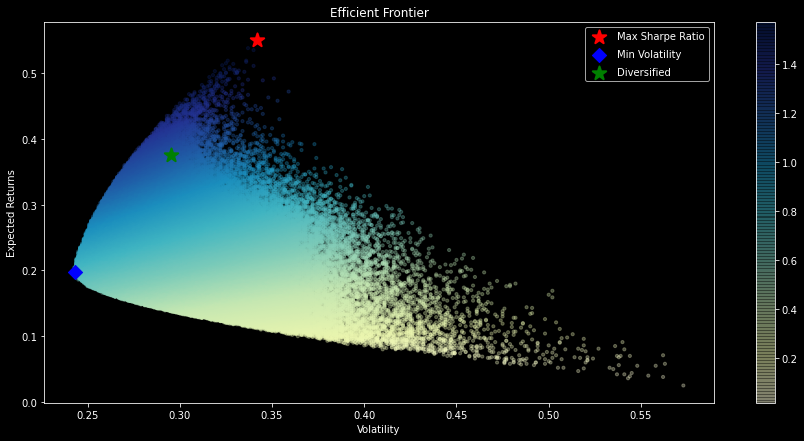

In [13]:
plt.figure(figsize=(15,7))
plt.scatter(x=portfolios['Volatility'], y=portfolios['Returns'], c= portfolios['Sharpe'], cmap='YlGnBu', marker='o', s=10, alpha=.3)
plt.colorbar()
plt.scatter(x=sharpe['Volatility'], y=sharpe['Returns'], color= 'r', marker='*', s=200, lw=2., label='Max Sharpe Ratio')
plt.scatter(x=min_vol['Volatility'], y=min_vol['Returns'], color= 'b', marker='D', s=100, lw=1., label='Min Volatility')
plt.scatter(x=diversified['Volatility'], y=diversified['Returns'], color= 'g', marker='*', s=200, lw=2., label='Diversified')
plt.xlabel('Volatility', color='white')
plt.ylabel('Expected Returns', color= 'white')
plt.title('Efficient Frontier', color='white')
plt.legend(labelspacing=.8)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()

In [14]:
print('Minimum Volatility Portfolio Balance')
print(min_vol.T)
print('\nMaximum Sharpe Ratio Portfolio Balance')
print(sharpe.T)
print('\nDiversified Portfolio Balance')
print(diversified.T)

Minimum Volatility Portfolio Balance
Returns        0.198
Volatility     0.243
AAPL Weight    0.011
AMZN Weight    0.333
PEP Weight     0.483
SONY Weight    0.142
TSLA Weight    0.031
Sharpe         0.751
Name: 7396, dtype: float64

Maximum Sharpe Ratio Portfolio Balance
              3864
Returns      0.551
Volatility   0.342
AAPL Weight  0.886
AMZN Weight  0.002
PEP Weight   0.053
SONY Weight  0.039
TSLA Weight  0.020
Sharpe       1.569

Diversified Portfolio Balance
             100126
Returns       0.375
Volatility    0.295
AAPL Weight   0.492
AMZN Weight   0.122
PEP Weight    0.163
SONY Weight   0.123
TSLA Weight   0.101
Sharpe        1.220


# Test performance in future

In [15]:
backtest_data = back_prices.copy()
initial_capital = 100000.0
print(backtest_data)

                  AAPL         AMZN         PEP       SONY        TSLA
Date                                                                  
2020-03-18   61.089394  1830.000000  117.352257  54.790001   72.244003
2020-03-19   60.621319  1880.930054  113.877876  55.400002   85.528000
2020-03-20   56.772747  1846.089966  100.863556  53.060001   85.505997
2020-03-23   55.566658  1902.829956  102.076668  52.900002   86.858002
2020-03-24   61.141407  1940.099976  110.481155  57.000000  101.000000
...                ...          ...         ...        ...         ...
2021-05-25  126.900002  3259.050049  148.300003  98.349998  604.690002
2021-05-26  126.849998  3265.159912  148.300003  98.419998  619.130005
2021-05-27  125.279999  3230.110107  146.509995  99.570000  630.849976
2021-05-28  124.610001  3223.070068  147.940002  99.610001  625.219971
2021-06-01  124.989998  3224.500000  147.509995  99.449997  626.059998

[304 rows x 5 columns]


In [16]:
print(diversified)
print()
opt_weights = (diversified.iloc[0:1,2:-1])
#print(opt_weights)

        Returns  Volatility  AAPL Weight  AMZN Weight  PEP Weight  \
100126    0.375       0.295        0.492        0.122       0.163   

        SONY Weight  TSLA Weight  Sharpe  
100126        0.123        0.101    1.22  



### Pull weights from optimal sharpe value portfolio

In [17]:
opt_weights = (diversified.iloc[0:1,2:-1])
opt_weights = opt_weights.values
opt_weights = (opt_weights[0])
opt_weights

array([0.492, 0.122, 0.163, 0.123, 0.101])

### Create df of positions for amt of shares per stock based upon portfolio weights

In [18]:
positions = pd.DataFrame(index=backtest_data.index).fillna(0.0)
for counter, symbol in enumerate(all_prices.columns.tolist()):
    positions[symbol+ ' Shares'] = (opt_weights[counter]*initial_capital)/back_prices.iloc[0,counter]

### Create list of column names for Portfolio df, fill in df values by multiplying stock value by stock position

In [19]:
# Create list of columns for portfolio
col_list= []
for counter, symbol in enumerate(all_prices.columns.tolist()):
    col_list.append(symbol+ ' Value')
# Initialize portfolio
portfolio = pd.DataFrame(backtest_data.values*positions.values, columns=col_list, index=backtest_data.index)
portfolio['total'] = portfolio.sum(axis=1)
portfolio['returns'] = portfolio['total'].pct_change()

# Show Portfolio performance 

### Get index returns and standardize prices

In [20]:
index_all_data = yf.download('^GSPC', start_date, end_date)
index_all_data['returns'] = index_all_data['Adj Close'].pct_change()

halfway = int(len(index_all_data.index)/2)
# Split prices into front prices for portfolio
# and back prices for future testing
index_front_data = index_all_data.iloc[:halfway,:]
index_back_data = index_all_data.iloc[halfway:,:]

[*********************100%***********************]  1 of 1 completed


In [21]:
portfolio['Std Value'] = portfolio['total'] / portfolio['total'].iloc[0] * 100
index_back_data['Std Value'] = index_back_data['Adj Close'] / index_back_data['Adj Close'].iloc[0] * 100
#print(portfolio.tail(5))
#print(index_back_data.tail(5))

### Plot portfolio value against index (standardized)


Current portfolio value is: $252,501.17
Portfolio annualized return is: 114.02%
Index annualized return is: 52.00%


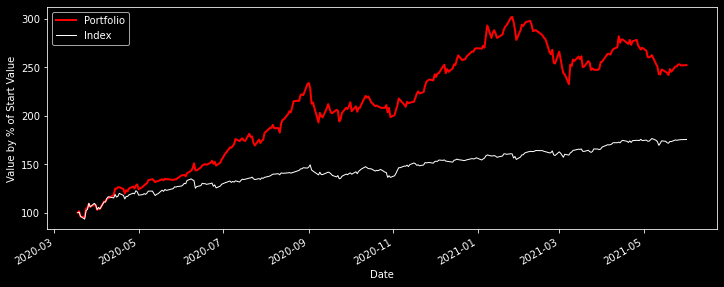

In [22]:
fig = plt.figure(figsize=(12,10))
#fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(211, ylabel='Value by % of Start Value')
portfolio['Std Value'].plot(ax=ax1, color='red', lw=2.)
index_back_data['Std Value'].plot(ax=ax1, color='white', lw=1.)
plt.legend(labels=['Portfolio', 'Index'], facecolor = 'black')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
# Get final value of portfolio
portfolio_value = (portfolio.iloc[-1,-3])
# Calc cumulative returns of port and index
cum_port_change = (1+portfolio['returns']).cumprod()
cum_index_change = (1+index_back_data['returns']).cumprod()
# Annualize
portfolio_cum_ret = (cum_port_change**(250/len(portfolio.index)))-1
index_cum_ret = (cum_index_change**(250/len(index_back_data.index)))-1
#print(portfolio_cum_ret)
# Slice most recent date
portfolio_ret= portfolio_cum_ret[-1]
index_ret = index_cum_ret[-1]

print('\nCurrent portfolio value is: $'+ str('{:,.2f}'.format(portfolio_value)))
print('Portfolio annualized return is: '+ str("{:.2%}".format(portfolio_ret)))
print('Index annualized return is: '+ str("{:.2%}".format(index_ret)))
plt.show()